# imports

In [342]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, recall_score, roc_curve, precision_score, accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Read Data

In [343]:
data = pd.read_csv("/Users/abrarsaad/Desktop/diabetic_data.csv")
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [344]:
data.shape

(101766, 50)

In [345]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

# Pre Proseccing

In [346]:
#Dealing with missing values,
data2 = data.copy() 
data2=data2.replace('?', np.NaN) 

In [347]:
data2.isnull().sum() 

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [348]:
#From the above we can see that "Weight,payer_code and medical_specialty" have a lot of missing values thus it is
#best to remove these values from the dataset.

#Dropping these columns,

data2= data2.drop(['weight','payer_code','medical_specialty'],axis=1)

In [349]:
data2.shape

(101766, 47)

In [350]:
# We can see that there are three types of values:- 'NO','<30','>30'. So, to make it a categorical variable so that different  
# ML techniques can be applies.

data2['readmit_new'] = np.where(data2['readmitted'] == 'NO', 0, 1)

In [351]:
data2.readmit_new.value_counts()     

0    54864
1    46902
Name: readmit_new, dtype: int64

In [352]:
#readmitted_dummies =pd.get_dummies(data2.readmitted, drop_first=False)
#data2= pd.concat([data2,readmitted_dummies],axis=1)
#data2

In [353]:
data2.shape

(101766, 48)

In [354]:
# Removing the pateints from the dataset that are dead.

data2 = data2[((data2.discharge_disposition_id != 11) & 
                                          (data2.discharge_disposition_id != 13) &
                                          (data2.discharge_disposition_id != 14) & 
                                          (data2.discharge_disposition_id != 19) & 
                                          (data2.discharge_disposition_id != 20) & 
                                          (data2.discharge_disposition_id != 21))]

In [355]:
data2.shape

(99343, 48)

In [357]:
# Cleaning the data, replacing the null values in numeric data by 0 and object data by unknown,
numcolumn = data2.select_dtypes(include = [np.number]).columns
objcolumn = data2.select_dtypes(include = ['object']).columns



In [358]:
# Substituting 0 and unknown,
data2[numcolumn] = data2[numcolumn].fillna(0)
data2[objcolumn] = data2[objcolumn].fillna("unknown")

In [359]:
# Checking nulls
print(data.isnull().sum())

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazo

In [369]:
data3=data2.head(10000)
data3

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmit_new
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,NO,0
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,Up,No,No,No,No,No,Ch,Yes,>30,1
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,Yes,NO,0
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,Up,No,No,No,No,No,Ch,Yes,NO,0
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,Steady,No,No,No,No,No,Ch,Yes,NO,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10200,43467342,17064945,Caucasian,Female,[40-50),1,18,7,2,43,...,No,No,No,No,No,No,No,No,NO,0
10201,43470036,16347411,Caucasian,Male,[60-70),3,18,4,7,46,...,No,No,No,No,No,No,No,Yes,NO,0
10202,43471104,23645403,Caucasian,Male,[60-70),5,3,17,4,25,...,Steady,No,No,No,No,No,Ch,Yes,NO,0
10203,43472100,62784027,AfricanAmerican,Male,[50-60),3,1,1,5,72,...,No,No,No,No,No,No,No,Yes,NO,0


# split data

In [394]:
X = data3.drop(['readmit_new'], axis =1)
X = pd.get_dummies(X)
y = data3['readmit_new']

In [395]:
X.shape

(10000, 1442)

In [396]:
y.shape

(10000,)

In [403]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
X_train_val, X_test, y_train_val, y_test = X_train_val.reset_index(drop=True),X_test.reset_index(drop=True),y_train_val.reset_index(drop=True),y_test.reset_index(drop=True)

In [404]:
to_scale = [col for col in X.columns if X[col].max()>1]

sc = StandardScaler()

scaled_train = sc.fit_transform(X_train_val[to_scale])
scaled_train = pd.DataFrame(scaled_train,columns=to_scale)

scaled_test = sc.fit_transform(X_test[to_scale])
scaled_test = pd.DataFrame(scaled_test,columns=to_scale)

#Replace the original columns with the scaled ones
for col in scaled_train:
    X_train_val[col] = scaled_train[col]
    X_test[col] = scaled_test[col]

In [405]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2,random_state=42)

In [406]:
models_dict = {'Model':[],
              'Accuracy':[],
              'Recall':[],
              'Precision':[],
              'F1 score':[],}

# Logistic Regression

In [409]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_val)

print("\nLogistic Regression Accuracy=",accuracy_score(y_val, y_pred))
print("Logistic Regression F1 score=",f1_score(y_val, y_pred))


Logistic Regression Accuracy= 1.0
Logistic Regression F1 score= 1.0


In [410]:
y_pred_proba = lr.predict_proba(X_val)[::,1]
lr_fpr, lr_tpr, lr_threshold = roc_curve(y_val, y_pred_proba)
lr_roc_auc = roc_auc_score(y_val, y_pred_proba)

models_dict['Model'].append("Logistic Regression ")
models_dict['Accuracy'].append(accuracy_score(y_val, y_pred))
models_dict['Recall'].append(recall_score(y_val, y_pred))
models_dict['Precision'].append(precision_score(y_val, y_pred))
models_dict['F1 score'].append(f1_score(y_val, y_pred))

<AxesSubplot:>

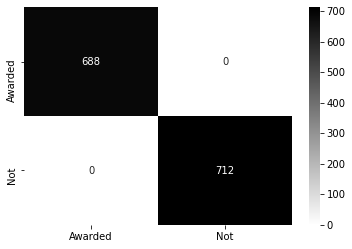

In [411]:
cm = confusion_matrix(y_val, y_pred)
class_label = ["Awarded", "Not"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d", cmap=plt.cm.binary)

# decision tree

In [412]:
# finding the best parameters for the decision tree
param_grid = {'criterion' :['gini', 'entropy'],
              'max_depth' : list(range(5,20)),
             'max_features': ['auto', 'sqrt', 'log2']}

tree_clas = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid,
                           cv=5, verbose=True, scoring = 'f1')
grid_search.fit(X_train_val, y_train_val)

print(grid_search.best_estimator_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
DecisionTreeClassifier(max_depth=18, max_features='auto', random_state=42)


In [413]:
# trying with entropy, since it didn't show in the previose step
tree = DecisionTreeClassifier(criterion='entropy',
                                     max_depth=8,
                                     max_features='auto',
                                     random_state=42)

tree.fit(X_train,y_train)
y_pred = tree.predict(X_val)

print("DT Accuracy=",accuracy_score(y_val, y_pred))
print("DT F1 score=",f1_score(y_val, y_pred))

DT Accuracy= 0.5478571428571428
DT F1 score= 0.4500434404865334


In [414]:
# stroring the best models in the dict
y_pred_proba = tree.predict_proba(X_val)[::,1]
dt_fpr, dt_tpr, dt_threshold = roc_curve(y_val, y_pred_proba)
dt_roc_auc = roc_auc_score(y_val, y_pred_proba)

models_dict['Model'].append("Decision Tree")
models_dict['Accuracy'].append(accuracy_score(y_val, y_pred))
models_dict['Recall'].append(recall_score(y_val, y_pred))
models_dict['Precision'].append(precision_score(y_val, y_pred))
models_dict['F1 score'].append(f1_score(y_val, y_pred))

<AxesSubplot:>

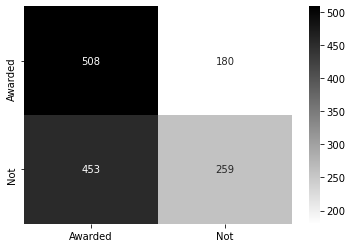

In [415]:
# plotting confusion mtrix
cm = confusion_matrix(y_val, y_pred)
class_label = ["Awarded", "Not"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d", cmap=plt.cm.binary)